In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import torch
import torch.nn as nn

from skimage import io
from skimage.transform import resize
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

random_state = 42
gen = random.Random(random_state)

data_dir = '../../allwavs/allvowl/corrected/extracted/img'
files = os.listdir(data_dir)
use_mel = True
files = [file for file in files if ('mel' in file) == use_mel]
#max_w = max(io.imread(data_dir + '/' + file).shape[1] for file in files)
#print(max_w)
gen.shuffle(files)
max_w = 31 # Measured

In [2]:
def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight.data)
        m.bias.data.fill_(0.01)
    return

In [3]:
class SpectrumDataset(Dataset):
    def __init__(self, data_dir, files):
        self.data_dir = data_dir
        self.files = [file for file in files if '~' not in file.split('__')[0]]
        gen.shuffle(self.files)
        all_phonemes = ['l', 'm', 'p', 's', 't', 't1']
        self.data = []
        for file in tqdm(self.files):
            split = file.split('__')
        
            gender = split[1]
            begin_time = float(split[2])
            end_time = float(split[3])
            phonemes = split[4].split('_')
            
            image = io.imread(self.data_dir + '/' + file, as_gray=True)
            image = resize(image, (image.shape[0], max_w), anti_aliasing=False)
            
            label = (begin_time, end_time)
            self.data.append((
            (torch.tensor(image).float(),
             torch.tensor([gender == 'f', len(phonemes) == 2, *[phonemes[0] == x for x in all_phonemes]])
            ), torch.tensor(label)))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

l = len(files)
train_size = 0.9
cutoff = int(l*train_size)

train_set = SpectrumDataset(data_dir, files[:cutoff])
test_set = SpectrumDataset(data_dir, files[cutoff:])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 408/408 [00:07<00:00, 53.35it/s]


tensor([[0.9947, 0.9924, 0.9952,  ..., 0.9976, 0.9962, 0.9973],
        [0.9319, 0.9297, 0.9324,  ..., 0.8818, 0.8679, 0.8793],
        [0.8234, 0.8200, 0.8242,  ..., 0.7612, 0.7500, 0.7591],
        ...,
        [0.5519, 0.5599, 0.5502,  ..., 0.4388, 0.4931, 0.4487],
        [0.5627, 0.6139, 0.5513,  ..., 0.4930, 0.5264, 0.4991],
        [0.5980, 0.6492, 0.5866,  ..., 0.5283, 0.5617, 0.5343]])
tensor([ True, False, False, False, False, False, False,  True])
tensor([0.2400, 0.8000])


Text(0.5, 1.0, 'tensor([0.2400, 0.8000])')

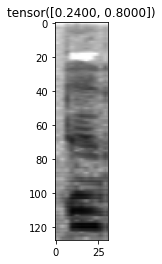

In [4]:
(im, features), label = train_set[0]
print(im)
print(features)
print(label)
plt.imshow(im.numpy(), cmap='gray')
plt.title(label)

In [5]:
class CNNRegressor(nn.Module):
    def __init__(self):
        super(CNNRegressor, self).__init__()
        
        self.cnn_layer1 = nn.Sequential(nn.Conv2d(1, 16, kernel_size=3, padding='valid'),
                                        nn.ReLU(),
                                        nn.Dropout(0.1),
                                        nn.BatchNorm2d(16),
                                        nn.MaxPool2d(kernel_size=2))
        self.cnn_layer2 = nn.Sequential(nn.Conv2d(16, 32, kernel_size=3, padding='valid'),
                                        nn.ReLU(),
                                        nn.Dropout(0.2),
                                        nn.BatchNorm2d(32),
                                        nn.MaxPool2d(kernel_size=2))
        self.linear_layer1 = nn.Linear(32*30*6 + 8, 64)
        self.dropout1 = nn.Dropout(0.5)
        self.activ1 = nn.ReLU()
        self.linear_layer_p = nn.Linear(64, 32)
        self.dropout_p = nn.Dropout(0.5)
        self.activ_p = nn.ReLU()
        self.linear_layer2 = nn.Linear(32, 2)
        self.activ2 = nn.Sigmoid()
        
    def forward(self, images, features):
        images = images.unsqueeze(1)
        
        cnn1 = self.cnn_layer1(images)
        cnn2 = self.cnn_layer2(cnn1)
        cnn_vec = cnn2.reshape(cnn2.shape[0], -1)
        cnn_cb = torch.cat((cnn_vec, features), dim=1)
        out = self.linear_layer1(cnn_cb)
        out = self.activ1(out)
        out = self.dropout1(out)
        out = self.linear_layer_p(out)
        out = self.dropout_p(out)
        out = self.activ_p(out)
        out2 = self.linear_layer2(out)
        out2 = self.activ2(out2)
        return out2

In [6]:
def eval_cnn_regressor(model, eval_dataloader, loss_fn):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for (images, features), labels in eval_dataloader:
            images = images.cuda()
            features = features.cuda()
            labels = labels.cuda()
            y_predicted = model(images, features)
            loss = loss_fn(y_predicted, labels)
            total_loss += loss.item()
    return total_loss/len(eval_dataloader)

def training_cnn_regressor(model, train_dataloader, num_epochs, loss_fn, learning_rate, verbose=True):
    model_tr = copy.deepcopy(model)
    model_tr.train()
    optimizer = torch.optim.AdamW(model_tr.parameters(), lr=0.001)
    scheduler = ReduceLROnPlateau(optimizer, 'min')
    loss_all_epochs = []
    test_loss_all_epochs = []

    if verbose:
        print(f'Epoch [0/{num_epochs}], Loss: {100*eval_cnn_regressor(model_tr, train_dataloader, loss_fn):.4f}, Test loss: {100*eval_cnn_regressor(model_tr, test_dataloader, loss_fn):.4f}')
    
    total = len(train_dataloader)
    for epoch in range(num_epochs):
        loss_current_epoch = 0
        for (images, features), labels in tqdm(train_dataloader, total=total):
            images = images.cuda()
            features = features.cuda()
            labels = labels.cuda()
            y_predicted = model_tr(images, features)
            loss = loss_fn(y_predicted, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_current_epoch += loss.item()
        
        loss_all_epochs.append(loss_current_epoch / total)
        test_loss = eval_cnn_regressor(model_tr, test_dataloader, loss_fn)
        test_loss_all_epochs.append(test_loss)
        if verbose:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {100*loss_current_epoch / total:.4f}, Test loss: {100*test_loss:.4f}')
        
    return model_tr, loss_all_epochs, test_loss_all_epochs

Total number of parameters:  376258
Epoch [0/23], Loss: 73.6072, Test loss: 73.6172


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 3558/3558 [00:11<00:00, 298.96it/s]


Epoch [1/23], Loss: 36.3995, Test loss: 35.0899


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 3558/3558 [00:11<00:00, 317.92it/s]


Epoch [2/23], Loss: 35.0764, Test loss: 34.8913


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 3558/3558 [00:11<00:00, 310.41it/s]


Epoch [3/23], Loss: 34.8671, Test loss: 34.9135


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 3558/3558 [00:11<00:00, 322.94it/s]


Epoch [4/23], Loss: 34.7830, Test loss: 34.9783


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 3558/3558 [00:11<00:00, 319.81it/s]


Epoch [5/23], Loss: 34.7032, Test loss: 34.7404


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 3558/3558 [00:11<00:00, 316.29it/s]


Epoch [6/23], Loss: 34.5547, Test loss: 34.8254


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 3558/3558 [00:12<00:00, 287.66it/s]


Epoch [7/23], Loss: 34.5173, Test loss: 34.6339


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 3558/3558 [00:11<00:00, 304.24it/s]


Epoch [8/23], Loss: 34.4267, Test loss: 34.6214


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 3558/3558 [00:11<00:00, 301.43it/s]


Epoch [9/23], Loss: 34.3467, Test loss: 34.9184


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 3558/3558 [00:11<00:00, 316.93it/s]


Epoch [10/23], Loss: 34.2751, Test loss: 34.6288


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 3558/3558 [00:10<00:00, 333.76it/s]


Epoch [11/23], Loss: 34.2293, Test loss: 34.6372


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 3558/3558 [00:11<00:00, 319.38it/s]


Epoch [12/23], Loss: 34.1953, Test loss: 34.6748


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 3558/3558 [00:11<00:00, 318.16it/s]


Epoch [13/23], Loss: 34.1594, Test loss: 34.5837


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 3558/3558 [00:10<00:00, 328.15it/s]


Epoch [14/23], Loss: 34.1342, Test loss: 34.6449


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 3558/3558 [00:11<00:00, 308.18it/s]


Epoch [15/23], Loss: 34.1201, Test loss: 34.7580


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 3558/3558 [00:11<00:00, 322.40it/s]


Epoch [16/23], Loss: 34.0626, Test loss: 34.6146


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 3558/3558 [00:10<00:00, 331.15it/s]


Epoch [17/23], Loss: 34.0859, Test loss: 34.6115


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 3558/3558 [00:11<00:00, 315.15it/s]


Epoch [18/23], Loss: 34.0748, Test loss: 34.5928


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 3558/3558 [00:12<00:00, 276.93it/s]


Epoch [19/23], Loss: 34.0092, Test loss: 35.0778


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 3558/3558 [00:10<00:00, 327.87it/s]


Epoch [20/23], Loss: 34.0475, Test loss: 34.6021


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 3558/3558 [00:11<00:00, 305.67it/s]


Epoch [21/23], Loss: 33.9874, Test loss: 34.7914


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 3558/3558 [00:11<00:00, 311.95it/s]


Epoch [22/23], Loss: 33.9942, Test loss: 34.5884


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 3558/3558 [00:10<00:00, 331.23it/s]


Epoch [23/23], Loss: 34.0468, Test loss: 34.6427


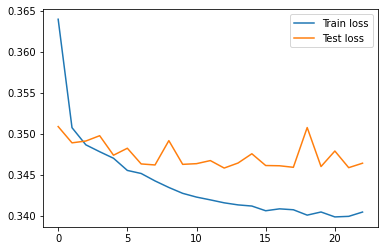

In [8]:
batch_size = 1
train_dataloader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(test_set, batch_size=batch_size)

model = CNNRegressor()

print('Total number of parameters: ', 
      sum(p.numel() for p in model.parameters()))

torch.manual_seed(0)
model.apply(init_weights)

num_epochs = 23
loss_fn = nn.BCELoss()
learning_rate = 0.01

model.cuda()
model, loss_total, test_loss_total = training_cnn_regressor(model, train_dataloader, num_epochs, loss_fn, learning_rate, verbose=True)

torch.save(model.state_dict(), 'model_cnn_regression.pt')
plt.plot(loss_total, label='Train loss')
plt.plot(test_loss_total, label='Test loss')
plt.legend()

plt.show()

In [9]:
total = 0
for (im, ft), lb in list(test_dataloader):
    im = im.cuda()
    ft = ft.cuda()
    y_pred = model(im, ft).detach().cpu()[0]
    y_true = lb[0]
    err = torch.mean((y_true - y_pred)**2)
    total += err
    out = '-'*int(err*100)
    if out:
        print(y_true, y_pred, err.item(), out)
print(total)

tensor([0.4815, 1.0000]) tensor([0.6258, 1.0000]) 0.010411578230559826 -
tensor([0.8286, 0.9143]) tensor([0.3152, 0.8295]) 0.1353638470172882 -------------
tensor([0.8065, 1.0000]) tensor([0.5711, 1.0000]) 0.02768407016992569 --
tensor([0.7000, 1.0000]) tensor([0.3348, 1.0000]) 0.0666699931025505 ------
tensor([0.2333, 1.0000]) tensor([0.5076, 1.0000]) 0.03761231154203415 ---
tensor([0.7407, 0.8518]) tensor([0.5782, 0.9184]) 0.015415070578455925 -
tensor([0.1111, 1.0000]) tensor([0.5678, 1.0000]) 0.10429280996322632 ----------
tensor([0.4074, 0.5185]) tensor([0.5452, 0.7305]) 0.0319695882499218 ---
tensor([0.1842, 0.9211]) tensor([0.3987, 0.8393]) 0.026350390166044235 --
tensor([0.4688, 0.9062]) tensor([0.4775, 0.7409]) 0.013704388402402401 -
tensor([0.1200, 1.0000]) tensor([0.4853, 1.0000]) 0.066727414727211 ------
tensor([0.1562, 0.3125]) tensor([0.2071, 0.9144]) 0.18245363235473633 ------------------
tensor([0.1539, 1.0000]) tensor([0.3307, 1.0000]) 0.015642231330275536 -
tensor([0.

In [378]:
model4

CNNRegressor(
  (cnn_layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cnn_layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layer1): Linear(in_features=5768, out_features=64, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (activ1): ReLU()
  (linear_layer_p): Linear(in_features=64, out_features=32, bias=True)
  (dropout_p): Dropout(p=0.5, inplace=False)
  (activ_p): ReLU()
  (linear_layer2): Linear(in_features=32, out_fe

In [10]:
torch.save(model, 'model_cnn_regress.fl')